# Sleep Prediction Analysis

## Intro

The goal of this notebook is to evaluate the difference predictions
between Accusleep and yasa classifiers for sleep staging using 3
electrodes (predictions are done using only one channel at a time). All
three predictions use the same EMG constructed as a difference between
the two EMG electrodes implanted and filtered between 10 and 50Hz.

## Pre-processing

During these steps, we read the data and correct formatting differences
between the 2 different classifiers.

In [ ]:
library(tidyverse)
devtools::source_url("https://raw.githubusercontent.com/matiasandina/phdutils/main/sleep/utils.R")
files <- list.files("2023-02-22/", pattern = "sleep.+.mat", full.names = T)
li <- map(
  files,
  import_mat_labels
) %>% 
  set_names(str_extract(basename(files), pattern="channel[0-9]+"))

df <- bind_cols(li) %>% 
  mutate(mode = apply(., 1, FUN = modeest::mfv1, simplify = T))

In [ ]:
df %>% 
  mutate(across(everything(), convert_accusleep_labels)) %>% 
  mutate(time_sec = make_time_column(sf = 0.5, length.out = n())) %>%  
  filter(channel04 != channel09)

Comparison with `yasa` using previously trained classifier. The
information for the classifier training can be found
[here](https://github.com/matiasandina/yasa_classifier)

In [ ]:
import yasa
from src.list_files import list_files 
from src.staging import SleepStaging
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
import pandas as pd
import mne
from mne.io import RawArray
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from src.sleep_utils import *

sf = 1000 #Hz
epoch_len = 2 #sec
emg_file = list_files(path="2023-02-22/eeg_mat", full_names=True, pattern="emg_diff")
eeg_files = sorted(list_files(path="2023-02-22/eeg_mat", full_names=True, pattern="channel04|channel08|channel09"))
# this is the fullpath to the model
path_to_model = '/home/matias/Dropbox (MIT)/Matias_Choi_Lab/analysis_pipelines/yasa_classifier/output/classifiers/clf_eeg+emg_lgb_gbdt_custom.joblib'
predictions = []
for i, file in enumerate(eeg_files):
  eeg, emg = get_files(eeg_files[i], emg_file[0])
  predictions.append(predict_mouse(eeg, emg, sf, epoch_sec=epoch_len, path_to_model=path_to_model))

/home/matias/.local/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/matias/.local/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/matias/.local/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at 

In [ ]:
accusleep_dict = {
    1:4,#"R",
    2:0,#"W",
    3:2,#"N"
  }

accusleep_df = r.df
accusleep_df = accusleep_df.apply(lambda col: col.map(accusleep_dict))
accusleep_df = accusleep_df.apply(yasa.hypno_int_to_str)

## Smoothing

The `yasa` classifier does not have a smoothing implementation to make
sure that the min continuous epoch length is of certain value (e.g., no
shorter than 4 seconds). We will add smoothing to evaluate if it
improves the predictions.

In [ ]:
df_mode = df.apply(lambda x: smooth_sequence(x, kernel_size=4, sf=0.5, method="mode"))
df_gap = df.apply(lambda x: smooth_sequence(x, kernel_size=4, sf=1, method="min_length"))

## Evaluation of Staging

When evaluating the different channels, there seems to be some lack of
agreement between the predictions.

### Accusleep vs Accusleep

Cohen's Kappa: 0.650012555744141
(0.8125459446214163, array([[2018,    0,   43],
       [   5,   71,    0],
       [ 522,  195, 1227]]), 0.650012555744141)

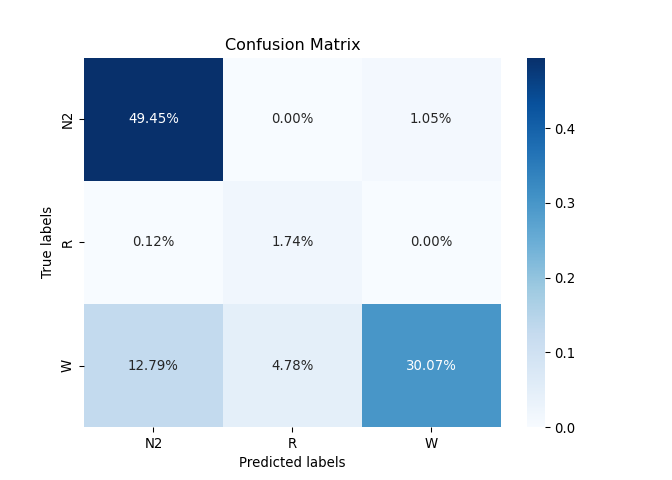

In [ ]:
evaluate(true_labels=df.eeg_channel08, 
         predicted_labels=df.eeg_channel04, 
         as_string=True, 
         plot_cm=True)

Cohen's Kappa: 0.7078818571441353
(0.8451359960793923, array([[2113,    4,   61],
       [   7,  127,    0],
       [ 425,  135, 1209]]), 0.7078818571441353)

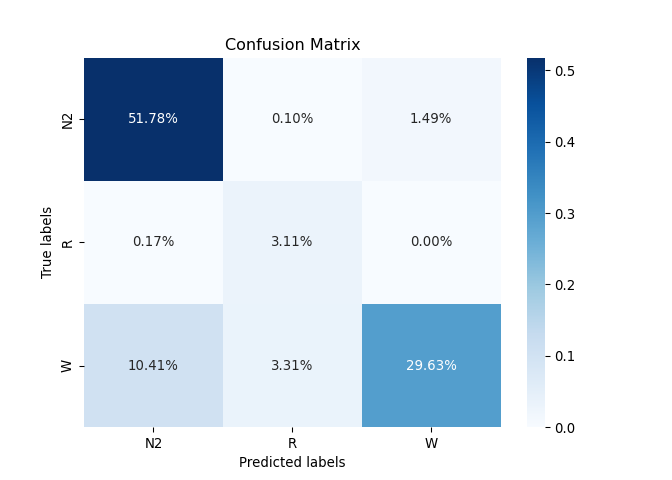

In [ ]:
evaluate(true_labels=df.eeg_channel08, 
         predicted_labels=df.eeg_channel09, 
         as_string=True, 
         plot_cm=True)

### yasa vs yasa

Cohen's Kappa: 0.650012555744141
(0.8125459446214163, array([[2018,    0,   43],
       [   5,   71,    0],
       [ 522,  195, 1227]]), 0.650012555744141)

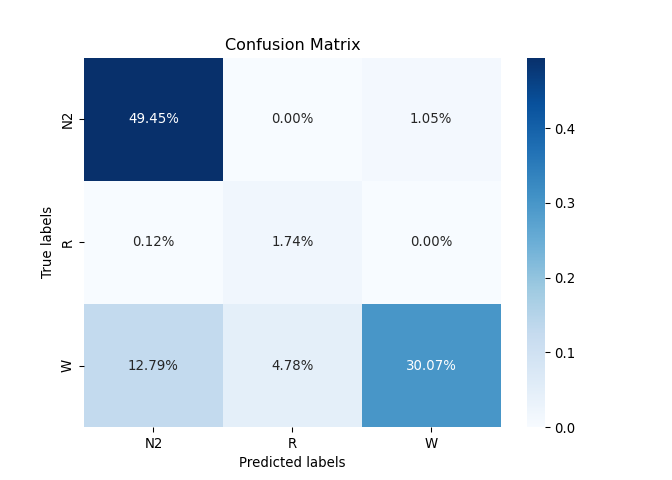

In [ ]:
evaluate(true_labels=df.eeg_channel08, 
         predicted_labels=df.eeg_channel04, 
         as_string=True, 
         plot_cm=True)

Cohen's Kappa: 0.7078818571441353
(0.8451359960793923, array([[2113,    4,   61],
       [   7,  127,    0],
       [ 425,  135, 1209]]), 0.7078818571441353)

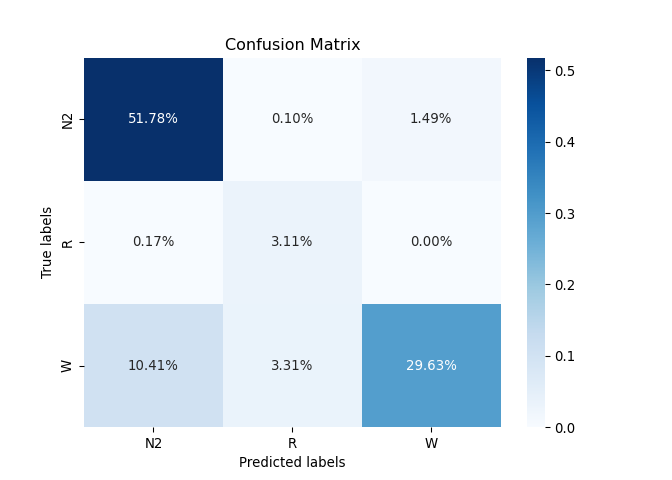

In [ ]:
evaluate(true_labels=df.eeg_channel08, 
         predicted_labels=df.eeg_channel09, 
         as_string=True, 
         plot_cm=True)

Cohen's Kappa: 0.7804198044118893
(0.8850771869639794, array([[1916,    2,  260],
       [   0,   73,   61],
       [ 145,    1, 1623]]), 0.7804198044118893)

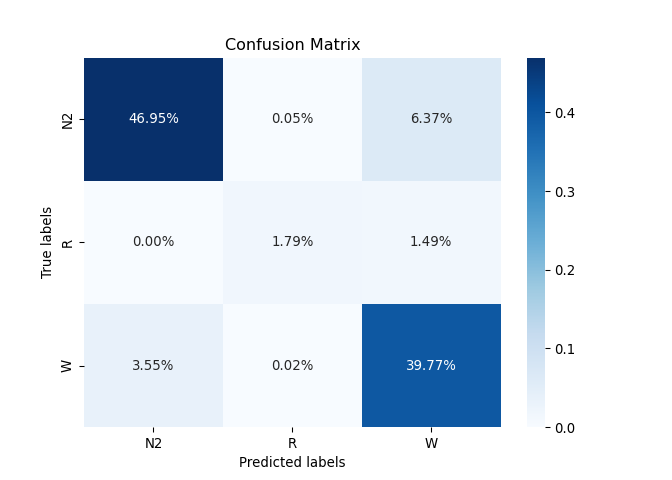

In [ ]:
evaluate(true_labels=df.eeg_channel04, 
         predicted_labels=df.eeg_channel09, 
         as_string=True, 
         plot_cm=True)

### yasa vs Accusleep

There seems to be little agreement between accusleep and yasa trained
with the previous classifier. It might be due to the calibration file
that we created in Accusleep. The values below are not incredibly
different from the previous disagreements between methos.

Cohen's Kappa: 0.49303127462447127
(0.7243322715020828, array([[2054,    1,    6],
       [   4,   72,    0],
       [ 827,  287,  830]]), 0.49303127462447127)

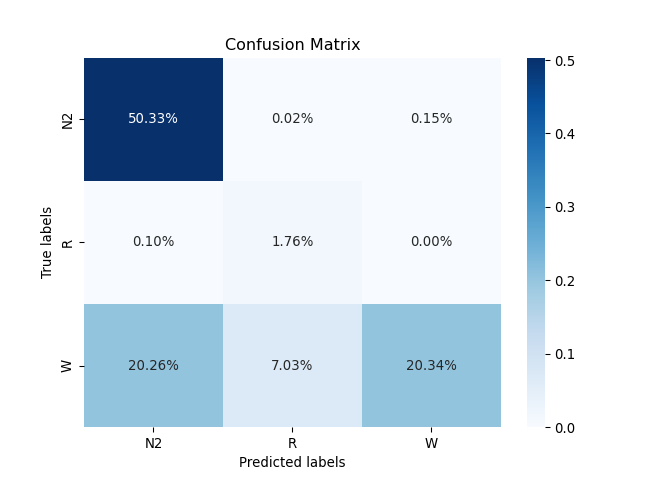

In [ ]:
evaluate(true_labels=accusleep_df.channel04, 
         predicted_labels=df.eeg_channel04, 
         as_string=True, 
         plot_cm=True)

Cohen's Kappa: 0.5448549485726218
(0.7926978681695663, array([[2525,   15,    5],
       [  21,  245,    0],
       [ 750,   55,  465]]), 0.5448549485726218)

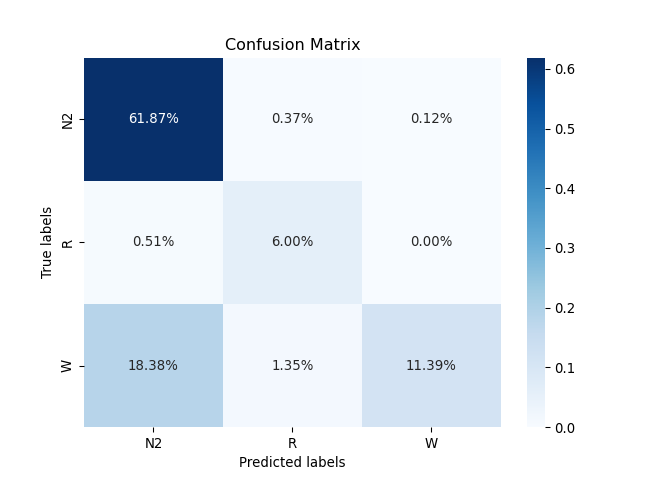

In [ ]:
evaluate(true_labels=accusleep_df.channel08, 
         predicted_labels=df.eeg_channel08, 
         as_string=True, 
         plot_cm=True)

Cohen's Kappa: 0.49321637250004235
(0.7324185248713551, array([[2162,    8,    8],
       [   7,  127,    0],
       [ 843,  226,  700]]), 0.49321637250004235)

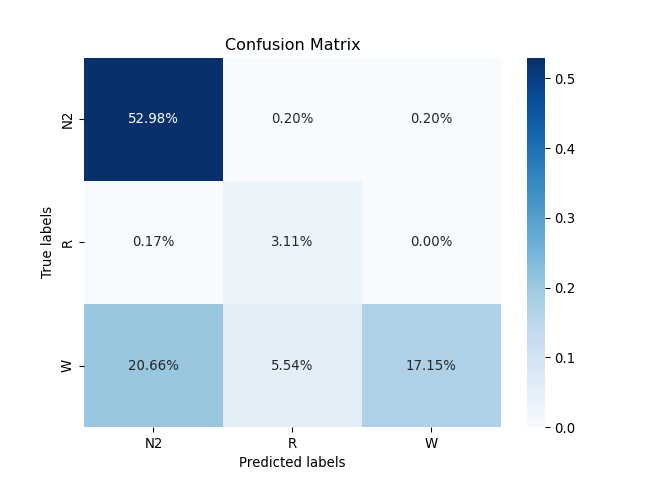

In [ ]:
evaluate(true_labels=accusleep_df.channel09, 
         predicted_labels=df.eeg_channel09, 
         as_string=True, 
         plot_cm=True)

Let’s see if the smoothing makes things better

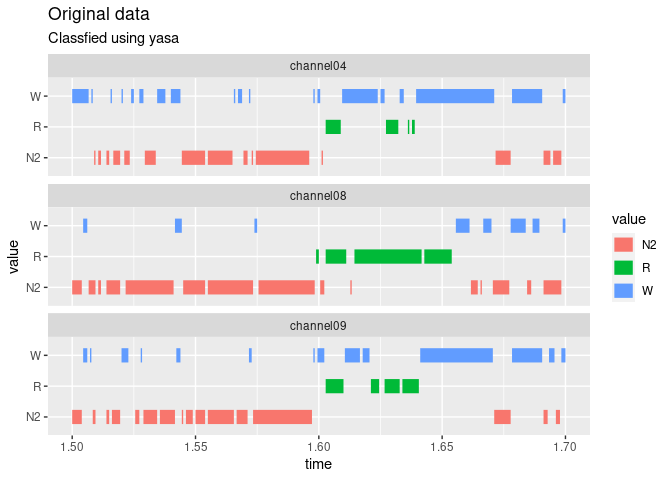

In [ ]:
library(ggethos)
library(reticulate)
hours_to_look <- c(1.5, 1.7)
ggplot(mutate(py$df,
              time = seconds_to_hours(make_time_column(sf = 0.5, length.out = n()))) %>%
         filter(data.table::between(time, hours_to_look[1], hours_to_look[2])) %>%
         pivot_longer(-time, names_to = "channel", names_prefix = "eeg_"),
       aes(time, value, behaviour = value, color= value)) +
  geom_ethogram() +
  facet_wrap(~channel, nrow = 3)+
  labs(title = "Original data",
       subtitle = "Classfied using yasa")

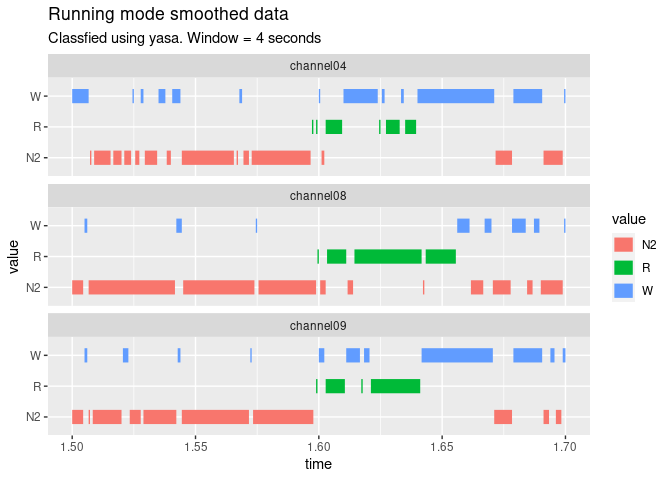

In [ ]:
ggplot(mutate(py$df_mode,
              time = seconds_to_hours(make_time_column(sf = 0.5, length.out = n()))) %>%
         filter(data.table::between(time, hours_to_look[1], hours_to_look[2])) %>%
         pivot_longer(-time, names_to = "channel", names_prefix = "eeg_"),
       aes(time, value, behaviour = value, color= value)) +
  geom_ethogram() +
  facet_wrap(~channel, nrow=3)+
  labs(title = "Running mode smoothed data",
       subtitle = "Classfied using yasa. Window = 4 seconds")

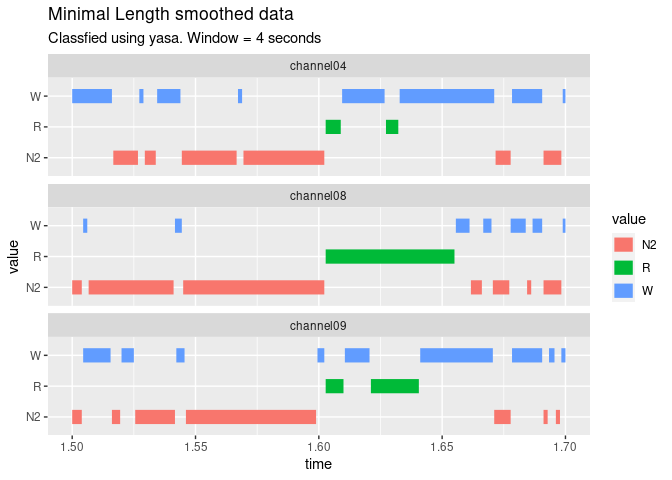

In [ ]:
ggplot(mutate(py$df_gap,
              time = seconds_to_hours(make_time_column(sf = 0.5, length.out = n()))) %>%
         filter(data.table::between(time, hours_to_look[1], hours_to_look[2])) %>%
         pivot_longer(-time, names_to = "channel", names_prefix = "eeg_"), 
       aes(time, value, behaviour = value, color= value)) +
  geom_ethogram() +
  facet_wrap(~channel, nrow=3)+
  labs(title = "Minimal Length smoothed data",
       subtitle = "Classfied using yasa. Window = 4 seconds")

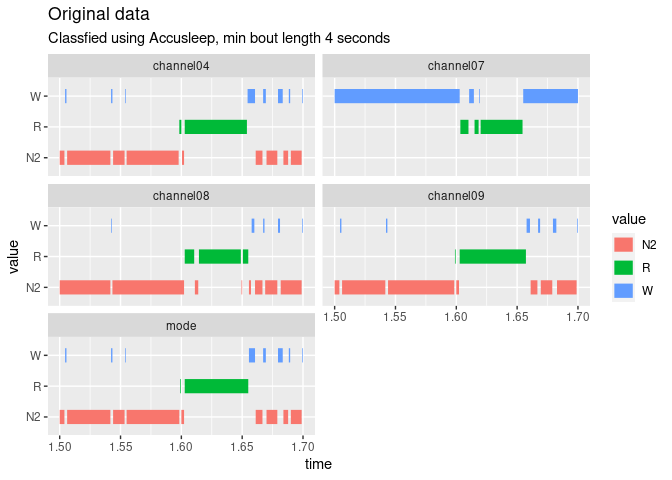

In [ ]:
ggplot(mutate(py$accusleep_df,
              time = seconds_to_hours(make_time_column(sf = 0.5, length.out = n()))) %>%
         filter(data.table::between(time, hours_to_look[1], hours_to_look[2])) %>%
         pivot_longer(-time, names_to = "channel", names_prefix = "eeg_"),
       aes(time, value, behaviour = value, color= value)) +
  geom_ethogram() +
  facet_wrap(~channel, nrow = 4)+
  labs(title = "Original data",
       subtitle = "Classfied using Accusleep, min bout length 4 seconds")